In [2]:
import os
import pandas as pd
import numpy as np
from glob import glob
import gspread
from haversine import haversine, Unit
import h3

# Goal: 
summarize the classification of each images from the prediction results
## 1. City-level summary
* use the classifier_city_agg.py

In [2]:
label = {0: 'Accra', 1: 'Amsterdam', 2: 'Antwerp', 3: 'Astrakhan', 4: 'Athens', 5: 'Auckland', 6: 'Bacolod', 7: 'Bangalore', 8: 'Bangkok', 9: 'Belgrade', 10: 'Belo Horizonte', 11: 'Berezniki', 12: 'Berlin', 13: 'Bogotá', 14: 'Boston', 15: 'Brussels', 16: 'Budapest', 17: 'Buenos Aires', 18: 'Capetown', 19: 'Cebu City', 20: 'Chicago', 21: 'Cirebon', 22: 'Cleveland', 23: 'Cochabamba', 24: 'Copenhagen', 25: 'Culiacan', 26: 'Curitiba', 27: 'Delhi', 28: 'Denver', 29: 'Detroit', 30: 'Dhaka', 31: 'Dubai', 32: 'Dzerzhinsk', 33: 'Florianopolis', 34: 'Fukuoka', 35: 'Gaborone', 36: 'Gainesville, FL', 37: 'Gombe', 38: 'Guadalajara', 39: 'Guatemala City', 40: 'Hindupur', 41: 'Hong Kong', 42: 'Houston', 43: 'Hyderabad', 44: 'Ilheus', 45: 'Istanbul', 46: 'Jaipur', 47: 'Jakarta', 48: 'Jalna', 49: 'Jequie', 50: 'Jerusalem', 51: 'Johannesburg', 52: 'Kampala', 53: 'Kanpur', 54: 'Kaunas', 55: 'Kigali', 56: 'Killeen', 57: 'Kozhikode', 58: 'Kuala Lumpur', 59: 'Kyiv', 60: 'Lagos', 61: 'Le Mans', 62: 'Lima', 63: 'London', 64: 'Los Angeles', 65: 'Madrid', 66: 'Malegaon', 67: 'Manchester', 68: 'Manila', 69: 'Medan', 70: 'Metro Manila', 71: 'Mexico City', 72: 'Miami', 73: 'Milan', 74: 'Minneapolis', 75: 'Modesto', 76: 'Montreal', 77: 'Moscow', 78: 'Mumbai', 79: 'Munich', 80: 'Nagoya', 81: 'Nairobi', 82: 'New York', 83: 'Okayama', 84: 'Palembang', 85: 'Palermo', 86: 'Palmas', 87: 'Parbhani', 88: 'Parepare', 89: 'Paris', 90: 'Philadelphia', 91: 'Portland, OR', 92: 'Pune', 93: 'Quito', 94: 'Rajshahi', 95: 'Raleigh', 96: 'Reynosa', 97: 'Ribeirao Preto', 98: 'Rio de Janeiro', 99: 'Rome', 100: 'Rovno', 101: 'Saidpur', 102: 'Saint Petersburg', 103: 'San Francisco', 104: 'Santiago', 105: 'Sao Paulo', 106: 'Seoul', 107: 'Sheffield', 108: 'Singapore', 109: 'Sitapur', 110: 'Stockholm', 111: 'Sydney', 112: 'Taipei', 113: 'Tel Aviv', 114: 'Thessaloniki', 115: 'Tokyo', 116: 'Toledo', 117: 'Toronto', 118: 'Tyumen', 119: 'Valledupar', 120: 'Victoria', 121: 'Vienna', 122: 'Vijayawada', 123: 'Warsaw', 124: 'Wellington', 125: 'Yamaguchi', 126: 'Zwolle'}
label_r = {}
for k,v in label.items():
    label_r[v] = k

In [5]:
def load_all():
    serviceaccount = "../../google_drive_personal.json"
    import gspread

    # from oauth2client.service_account import ServiceAccountCredentials
    gc = gspread.service_account(filename=serviceaccount)


    def read_url(url, SHEET_NAME):
        SHEET_ID = url.split("/")[5]
        spreadsheet = gc.open_by_key(SHEET_ID)
        worksheet = spreadsheet.worksheet(SHEET_NAME)
        rows = worksheet.get_all_records()
        df_spread = pd.DataFrame(rows)
        return df_spread, worksheet


    url = "https://docs.google.com/spreadsheets/d/1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw/edit?usp=sharing"
    SHEETNAME = "select_city_classifier"
    city_meta, other_worksheet = read_url(url, SHEETNAME)
    city_meta = city_meta[city_meta['City']!=''].reset_index(drop = True)
    return city_meta

city_meta = load_all()

In [6]:
city_meta.to_csv("../city_meta.csv", index = False)

In [63]:
# CURATED_FOLDER_TARGET = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_city_classifier_agg"
# CURATED_FOLDER_SOURCE = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_city_classifier_infer" # folder to archive
CURATED_FOLDER_SOURCE = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_city_classifier_agg"
# CURATED_FOLDER_SOURCE_CLEAN = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_city_classifier_infer_notrain"
TRANSFORMED_FOLDER = "/lustre1/g/geog_pyloo/05_timemachine/_transformed/t_classifier"

# TO_PRED_CITYLS = os.listdir(TRANSFORMED_FOLDER)
CITYLS = os.listdir(CURATED_FOLDER_SOURCE)
# ALLPRED = glob(CURATED_FOLDER_SOURCE+"/*/*.parquet")
# print("Total cities: ", len(CITYLS))
# print("Total files: ", len(ALLPRED))
CURATED_SUMMARY_FOLDER = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_city_classifier_summary"
if not os.path.exists(CURATED_SUMMARY_FOLDER):
    os.makedirs(CURATED_SUMMARY_FOLDER)
if not os.path.exists(CURATED_FOLDER_SOURCE_CLEAN):
    os.makedirs(CURATED_FOLDER_SOURCE_CLEAN)

In [14]:
city_meta.groupby('Continent').size().reset_index().rename(columns = {0:'city selected'})\
.to_csv(os.path.join(CURATED_SUMMARY_FOLDER , "continent_summary.csv"), index = False)

In [15]:
city_meta.groupby('Continent').size().reset_index().rename(columns = {0:'city selected'})

,Continent,city selected
0,Africa,10
1,Asia,41
2,Australia,1
3,Europe,33
4,North America,21
5,South America,21


In [65]:
# check yolofolder and load all training data using classifier_city_agg.py
from glob import glob
from tqdm import tqdm

def clean_city(city):
    
    """Remove the test data that share same panoid from the training set to avoid data leakage"""
    cityabbr = city.lower().replace(" ", "")
    yolofolder = f"/lustre1/g/geog_pyloo/05_timemachine/_transformed/t_classifier_img_yolo8/train/{city}"
    allfiles = glob(yolofolder+"/*.jpg")
    df_train = pd.DataFrame(allfiles, columns = ["path"])
    df_train['name'] = df_train["path"].apply(lambda x: x.split("/")[-1])
    df_train['panoid'] = df_train["name"].apply(lambda x: x[:22])
    pred_df = pd.read_parquet(os.path.join(CURATED_FOLDER_SOURCE, "c_"+cityabbr+".parquet"))
    pred_df["panoid"] = pred_df["name"].apply(lambda x: x[:22])
    pred_df = pred_df[~pred_df['panoid'].isin(df_train['panoid'].values)]
    print("remaining data shape: ", pred_df.shape[0])
    # pred_df.to_parquet(os.path.join(CURATED_FOLDER_SOURCE_CLEAN, "c_"+cityabbr+".parquet"))
    return pred_df

# allresults = []
# for city in tqdm(city_meta["City"].unique()):
#     pred_df = clean_city(city)
#     pred_sum = pred_df.groupby("top_1").size().reset_index().rename(columns = {0:"count"})
#     allresults.append(pred_sum)
    
# allresults = pd.concat(allresults).reset_index(drop = True)
# allresults["top_1_pre"] = allresults["top_1"].apply(lambda x: label[x])
# allresults["total_count"] = allresults.groupby("city")["count"].transform("sum")
# allresults["pre_pro"] = allresults["count"]/allresults["total_count"]

# allresults.to_parquet(os.path.join(CURATED_FOLDER_TARGET, "c_classifier_city_agg.parquet"), index = False)

In [3]:
# Script here to drop
from tqdm import tqdm
CURATED_FOLDER_SOURCE = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_city_classifier_infer" # folder to archive
allresults = []
for city in tqdm(CITYLS):
    city_pred = glob(CURATED_FOLDER_SOURCE +"/"+city+"/*.parquet")
    temp_df = []
    for p in tqdm(city_pred):
        temp = pd.read_parquet(p)
        # make sure the inference data does not exist in the training set.
        
        temp_df.append(temp)
    temp_df = pd.concat(temp_df).reset_index(drop = True)
    temp_sum = temp_df.groupby('top_1').size().reset_index().rename(columns = {0:"count"})
    temp_sum['city'] = city
    allresults.append(temp_sum)
allresults = pd.concat(allresults).reset_index(drop = True)
allresults["top_1_pre"] = allresults["top_1"].apply(lambda x: label[x])
allresults["total_count"] = allresults.groupby("city")["count"].transform("sum")
allresults["pre_pro"] = allresults["count"]/allresults["total_count"]

allresults.to_parquet(os.path.join(CURATED_FOLDER_TARGET, "c_classifier_city_agg.parquet"), index = False)

[]

In [16]:
# testing
allresults = pd.read_parquet(os.path.join(CURATED_FOLDER_TARGET, "c_classifier_city_agg.parquet"))
allresults["img_total"] = allresults.groupby("city")["count"].transform('sum')
allresults["prop"] = allresults["count"]/allresults["img_total"]
allresults["pred_city"] = allresults["top_1"].apply(lambda x: label[x].lower().replace(" ", ""))
allresults[allresults["city"]=="milan"].sort_values("prop", ascending = False).head(20)

,top_1,count,city,top_1_pre,total_count,pre_pro,img_total,prop,pred_city
12660,73,128760,milan,Milan,168753,0.763009,168753,0.763009,milan
12674,89,3887,milan,Paris,168753,0.023034,168753,0.023034,paris
12684,99,3219,milan,Rome,168753,0.019075,168753,0.019075,rome
12705,121,2391,milan,Vienna,168753,0.014169,168753,0.014169,vienna
12653,65,2113,milan,Madrid,168753,0.012521,168753,0.012521,madrid
12608,16,1972,milan,Budapest,168753,0.011686,168753,0.011686,budapest
12601,9,1965,milan,Belgrade,168753,0.011644,168753,0.011644,belgrade
12706,123,1686,milan,Warsaw,168753,0.009991,168753,0.009991,warsaw
12604,12,1557,milan,Berlin,168753,0.009227,168753,0.009227,berlin
12671,85,1333,milan,Palermo,168753,0.007899,168753,0.007899,palermo


In [19]:
allresults[allresults["city"]=="taipei"].sort_values("prop", ascending = False).head(20)

,top_1,count,city,top_1_pre,total_count,pre_pro,img_total,prop,pred_city
10919,112,202685,taipei,Taipei,255965,0.791847,255965,0.791847,taipei
10850,41,11725,taipei,Hong Kong,255965,0.045807,255965,0.045807,hongkong
10914,106,3888,taipei,Seoul,255965,0.015190,255965,0.015190,seoul
10922,115,2692,taipei,Tokyo,255965,0.010517,255965,0.010517,tokyo
10866,58,2232,taipei,Kuala Lumpur,255965,0.008720,255965,0.008720,kualalumpur
10916,108,2171,taipei,Singapore,255965,0.008482,255965,0.008482,singapore
10829,19,2041,taipei,Cebu City,255965,0.007974,255965,0.007974,cebucity
10876,68,1567,taipei,Manila,255965,0.006122,255965,0.006122,manila
10856,47,1501,taipei,Jakarta,255965,0.005864,255965,0.005864,jakarta
10818,8,1296,taipei,Bangkok,255965,0.005063,255965,0.005063,bangkok


## 2. Hexagon-level summary
1. What are the second most frequent misclassified city for each city at each hexagon level? Are there any pattern associated with city identity, cultural history, etc?
* Use the classifier_hexagon_agg.py to do it here.


In [ ]:
CURATED_FOLDER_TARGET = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_city_classifier_agg_hex"
CURATED_FOLDER_SOURCE = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_city_classifier_agg"
RAW_PATH = "/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/{city}/gsvmeta/{city}_meta.csv"
city_upper = "London"
print(city_upper)
city = city_upper.lower().replace(" ", "")
FILE_NAME = f"c_{city}.parquet"
pred_df = pd.read_parquet(os.path.join(CURATED_FOLDER_SOURCE, FILE_NAME))

# load the meta data
df_meta = pd.read_csv(RAW_PATH.format(city = city))
df_meta['name'] = df_meta["path"].apply(lambda x: x.split("/")[-1])
print(pred_df.shape[0])
for res in [8,9,12]:
    df_meta[f'h3_{res}'] = df_meta.apply(lambda x: h3.geo_to_h3(x.lat, x.lon, res), axis=1)
    
df_temp = pred_df.merge(df_meta.drop("panoid", axis = 1), on = "name")
res = 9
df_agg = df_temp.groupby(['top_1',f'h3_{res}']).size().reset_index().rename(columns = {0:"count"})
df_agg["img_count"] = df_agg.groupby(f"h3_{res}")["count"].transform('sum')

# get the pooled results that are definitely correct
df_sel = df_agg[df_agg["top_1"]==label_r[city_upper]].reset_index(drop = True)
df_sel["correct_class_prop"] = df_sel["count"]/df_sel["img_count"]

# give a class to the model selected city
df_agg['max_count'] = df_agg.groupby(f"h3_{res}")["count"].transform('max')

# STEP 2: identify the top 1 classification per hexagon (both true and false)
df_model = df_agg[df_agg["max_count"]==df_agg["count"]].reset_index(drop = True)
df_model["sel_class"] = df_model["top_1"].apply(lambda x: label[x])
df_model['winning_prop'] = df_model['max_count']/df_model['img_count'] # if <0.5, meaning rather random

# STEP 3: identify the top 1 false classification per hexagon
df_agg_false = df_agg[df_agg['top_1']!=label_r[city_upper]].reset_index(drop = True)
df_agg_false["max_count_false"] = df_agg_false.groupby("h3_9")["count"].transform("max")
df_agg_false_top1 = df_agg_false[df_agg_false["max_count_false"]==df_agg_false["count"]].reset_index(drop = True)
df_agg_false_top1["top_1_false_prop"] = df_agg_false_top1["max_count_false"]/df_agg_false_top1["img_count"]
df_agg_false_top1['top_1_false'] = df_agg_false_top1['top_1'].apply(lambda x: label[x])
df_agg_false_top1 = df_agg_false_top1[['h3_9','max_count_false', 'top_1_false_prop','top_1_false']].reset_index(drop = True)

# step 4: get all basics
df_basics = df_meta[['h3_9','dist_hav','ring','panoid']].drop_duplicates().dropna(subset = "h3_9")
df_basics = df_basics[df_basics["h3_9"]!=0].reset_index(drop = True)
df_basics = df_basics[["dist_hav", "ring", "h3_9"]].groupby("h3_9").mean().reset_index()
# summarize all hex level information
df_summary = df_model[["h3_9", "img_count","sel_class", "winning_prop"]]\
.merge(df_sel[["h3_9", "correct_class_prop"]], on = "h3_9", how = "left")\
.merge(df_basics, on = "h3_9", how = "left")\
.merge(df_agg_false_top1, on = "h3_9", how = "left")


df_summary["correct_class_prop"] = df_summary["correct_class_prop"].fillna(0) # meaning this hexagon has never been correctly classified
df_summary["top_1_false_prop"] = df_summary["top_1_false_prop"].fillna(0) # when all are correct, nothing wrong
df_summary['ring'] = df_summary['ring'].fillna(9)

In [161]:
df_agg_false_top1.head()

,top_1,h3_9,count,img_count,max_count,max_count_false,top_1_false_prop,top_1_false
0,0,89194ad2d87ffff,1,76,73,1,0.013158,Accra
1,1,89194ac004bffff,1,20,18,1,0.050000,Amsterdam
2,1,89194ac00dbffff,31,116,31,31,0.267241,Amsterdam
3,1,89194ac0317ffff,32,120,32,32,0.266667,Amsterdam
4,1,89194ac034bffff,9,64,32,9,0.140625,Amsterdam


In [159]:
df_basics.head()

,h3_9,dist_hav,ring
0,0,NaN,NaN
1,89194ac0003ffff,20634.711665,1.0
2,89194ac0007ffff,20877.063551,1.0
3,89194ac000bffff,20687.842921,1.0
4,89194ac000fffff,20937.686827,1.0


In [80]:
from shapely.geometry import Polygon
import geopandas as gpd

def cell_to_shapely(cell):
    coords = h3.h3_to_geo_boundary(cell)
    flipped = tuple(coord[::-1] for coord in coords)
    return Polygon(flipped)

In [115]:
# get proportion of correctness at each hexagon level
h3_geoms = df_summary[f'h3_{res}'].apply(lambda x: cell_to_shapely(x))
df_sel_gdf = gpd.GeoDataFrame(df_summary, geometry = h3_geoms)
df_sel_gdf.crs = "EPSG:4326"

<Axes: >

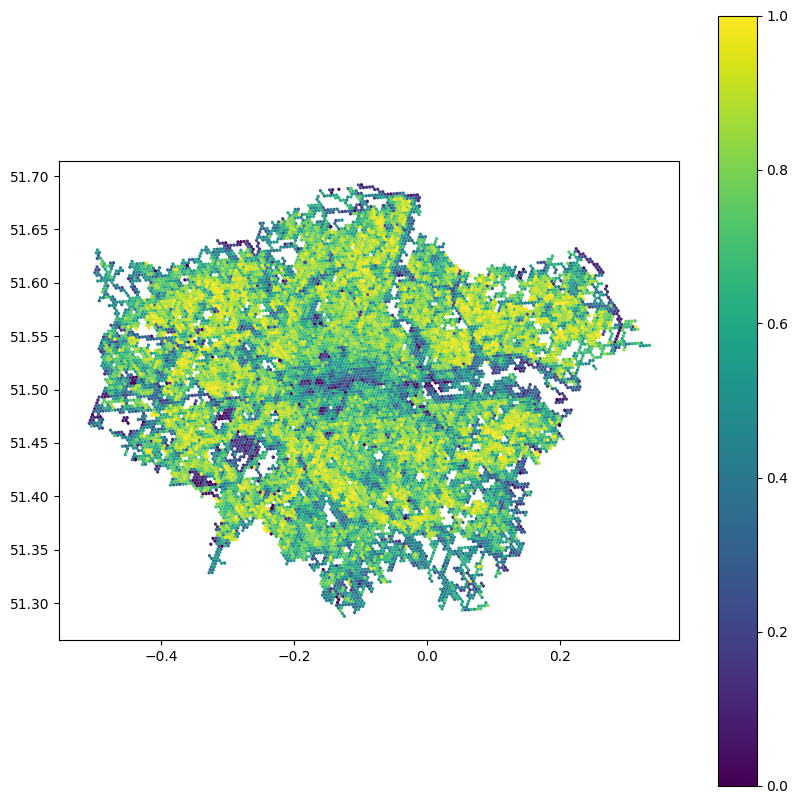

In [116]:
df_sel_gdf.plot(column = "correct_class_prop", figsize = (10,10), legend = True)

# Visualize all cities' similarity relationships

In [14]:
CURATED_FOLDER_TARGET = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_city_classifier_agg_hex"
df_summary = pd.read_csv(os.path.join(CURATED_FOLDER_TARGET, "c_hex_agg_all.csv"))

# most unidentifieable city
df_summary['correct'] = df_summary['sel_class']==df_summary["source_city"]
df_summary_city = df_summary.groupby(['source_city'])['correct'].mean().reset_index()
df_summary_city.sort_values("correct", ascending = True).head(10)

# construct a dataframe with city <> mis_classified_city, proportion of missclassification per hex
df_summary['total_hex'] = df_summary.groupby("source_city")["h3_9"].transform("count")
df_summary_rel = df_summary.groupby(["source_city", "top_1_false",'total_hex']).size().reset_index().rename(columns = {0:"top1_false_count"})
df_summary_rel['top1_false_prop'] = df_summary_rel["top1_false_count"]/df_summary_rel['total_hex']
df_summary_rel

In [15]:
# df_summary['sel_class_lower'] = df_summary['sel_class'].apply(lambda x: x.lower().replace(" ", ""))

In [25]:
df_summary_rel[df_summary_rel['source_city']=='Hong Kong'].sort_values("top1_false_prop", ascending = False)[:10]

,source_city,top_1_false,total_hex,top1_false_count,top1_false_prop
3284,Hong Kong,Taipei,8179,1738,0.212495
3281,Hong Kong,Singapore,8179,778,0.095122
3237,Hong Kong,Kuala Lumpur,8179,768,0.093899
3279,Hong Kong,Seoul,8179,474,0.057953
3207,Hong Kong,Cebu City,8179,450,0.055019
3219,Hong Kong,Florianopolis,8179,278,0.033989
3196,Hong Kong,Bangkok,8179,272,0.033256
3229,Hong Kong,Jakarta,8179,155,0.018951
3260,Hong Kong,Palermo,8179,127,0.015528
3193,Hong Kong,Athens,8179,109,0.013327


In [26]:
df_summary_rel[df_summary_rel['source_city']=='Paris'].sort_values("top1_false_prop", ascending = False)[:10]

,source_city,top_1_false,total_hex,top1_false_count,top1_false_prop
6546,Paris,Milan,2070,223,0.107729
6510,Paris,Berlin,2070,160,0.077295
6541,Paris,Madrid,2070,144,0.069565
6515,Paris,Buenos Aires,2070,108,0.052174
6538,Paris,Le Mans,2070,97,0.046860
6504,Paris,Antwerp,2070,97,0.046860
6577,Paris,Vienna,2070,91,0.043961
6562,Paris,Santiago,2070,71,0.034300
6564,Paris,Seoul,2070,69,0.033333
6532,Paris,Istanbul,2070,63,0.030435


In [27]:
df_summary_rel[df_summary_rel['source_city']=='New York'].sort_values("top1_false_prop", ascending = False)[:10]

,source_city,top_1_false,total_hex,top1_false_count,top1_false_prop
6122,New York,Philadelphia,8566,2934,0.342517
6073,New York,Boston,8566,1901,0.221924
6141,New York,Toronto,8566,616,0.071912
6115,New York,Montreal,8566,306,0.035723
6130,New York,San Francisco,8566,301,0.035139
6076,New York,Buenos Aires,8566,243,0.028368
6106,New York,Madrid,8566,239,0.027901
6086,New York,Detroit,8566,238,0.027784
6079,New York,Chicago,8566,167,0.019496
6132,New York,Seoul,8566,162,0.018912


In [28]:
df_summary_rel[df_summary_rel['source_city']=='Tokyo'].sort_values("top1_false_prop", ascending = False)[:10]

,source_city,top_1_false,total_hex,top1_false_count,top1_false_prop
8556,Tokyo,Fukuoka,15129,5286,0.349395
8594,Tokyo,Okayama,15129,2383,0.157512
8612,Tokyo,Seoul,15129,1779,0.117589
8627,Tokyo,Yamaguchi,15129,1355,0.089563
8617,Tokyo,Taipei,15129,960,0.063454
8598,Tokyo,Paris,15129,258,0.017053
8591,Tokyo,Nagoya,15129,217,0.014343
8560,Tokyo,Hong Kong,15129,200,0.013220
8565,Tokyo,Jakarta,15129,154,0.010179
8614,Tokyo,Singapore,15129,104,0.006874
